In [2]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib widget
import os
from scipy.signal import savgol_filter
from scipy.optimize import root
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib import ticker

In [14]:
'''defaults for plotting + some util fxns'''
fontsize_legend = 9
fontsize_axes = 12
fontsize_ticks = 8
linewidth_all = 2
markersize_all = 4
size_extra = 1

width_half = 3.3
height_half = 2.8
height_three = 2.5

width_whole = 6.8
width_complete = 7

figsize_whole = (6,5)
figsize_three = (15,5)
figsize_three_vert = (6, 13)
figsize_two = (10,5)
figsize_four_vert = (8, 17)
folder_out = 'figures_paper'
folder_exp = 'exp_results'
folder_out_extra = 'figures_ses'

# color_2folds = 'palevioletred'
color_2folds = 'goldenrod'
color_3folds = 'firebrick'
color_4folds = 'steelblue'
# color_4folds = 'deepskyblue'

vol_label = 'Normalized Volume $\Delta V/V_0$ [-]'
pressure_label = 'Pressure $P$ [kPa]'

colors_all = [color_2folds, color_3folds, color_4folds]

def smooth_pv_data(pressure, window_len = 100):
    # window_len = 100
    poly_order = 2
    len_pressure, num_exp = np.shape(pressure)

    pressure_smooth = np.zeros((len_pressure, num_exp))

    for i in range(num_exp):
        pressure_smooth[:,i] = savgol_filter(pressure[:,i], window_len, poly_order)
    
    return pressure_smooth

def rescale_eigenvalue(eigenvalues_cur):
    return np.sign(eigenvalues_cur) * np.sqrt(np.abs(eigenvalues_cur)) * 1/(2*np.pi)

def highlight_mode(freq_all, initial_i, initial_j, num_samp, num_pts = 2, select_fac = 1):
    j_all = np.zeros(np.shape(freq_all)[0], dtype = int)
    i_all = np.arange(np.shape(freq_all)[0], dtype = int)
    j_all[initial_i] = initial_j
    cut_idx = initial_i[0] + np.arange(num_samp + 2)

    for idx in range(0, num_samp, select_fac):
        i_next = idx + initial_i[1] + select_fac #min value 2

        if idx <= select_fac * (num_pts - 2): num_pts_temp = 2
        else: num_pts_temp = num_pts

        if idx == 0: i_cur = [i_next - select_fac - 1, i_next - select_fac]
        else: i_cur = [i_next - select_fac * (num_pts_temp - i) for i in range(num_pts_temp)]
        j_cur = [j_all[i] for i in i_cur]
        
        vals_cur = np.array([freq_all[i,j] for i,j in zip(i_cur, j_cur)])

        if idx == 0: val_new_est = vals_cur[-1] + select_fac * np.mean(np.diff(vals_cur))
        else: val_new_est = vals_cur[-1] + np.mean(np.diff(vals_cur))

        j_all[i_next] = np.argmin(np.abs(freq_all[i_next,:] - val_new_est))

        if select_fac > 1:
            j_all[i_cur[-1] + 1:i_next] = int(np.mean([j_all[i_cur[-1]], j_all[i_next]]))
    return (i_all, j_all, cut_idx)


In [4]:
'''improve plot fxns'''
def improve_plot_multi(axis, xlabel = '', ylabel = '', ylim_top = None, ylim_bottom = None, xlim_left = None, xlim_right = None, sharex = False, sharey = False):
    if isinstance(axis, np.ndarray):
        #is a list, do list things
        if not isinstance(xlabel, list): xlabel = [xlabel] * len(axis)
        if not isinstance(ylabel, list): ylabel = [ylabel] * len(axis)
        if not isinstance(ylim_top, list): ylim_top = [ylim_top] * len(axis)
        if not isinstance(ylim_bottom, list): ylim_bottom = [ylim_bottom] * len(axis)
        if not isinstance(xlim_left, list): xlim_left = [xlim_left] * len(axis)
        if not isinstance(xlim_right, list): xlim_right = [xlim_right] * len(axis)

        for i in range(len(axis)):
            axis[i].tick_params(labelsize = fontsize_ticks)
        
        if axis[0].get_gridspec().ncols > 1:
            #single row, assuming set ylabel on [0] only unless sharey is False
            for i in range(len(axis)):
                if i == 0 or not sharey:
                    improve_plot(axis[i], xlabel = xlabel[i], ylabel = ylabel[i], ylim_top = ylim_top[i], ylim_bottom = ylim_bottom[i], xlim_left = xlim_left[i], xlim_right = xlim_right[i])
                else:
                    improve_plot(axis[i], xlabel = xlabel[i], xlim_left = xlim_left[i], xlim_right = xlim_right[i])
                    
        else:
            #single col
            for i in range(len(axis)):
                if i == len(axis)-1 or not sharex:
                    improve_plot(axis[i], xlabel = xlabel[i], ylabel = ylabel[i], ylim_top = ylim_top[i], ylim_bottom = ylim_bottom[i], xlim_left = xlim_left[i], xlim_right = xlim_right[i])
                else:
                    improve_plot(axis[i], ylabel = ylabel[i], ylim_top = ylim_top[i], ylim_bottom = ylim_bottom[i])
    else:
        #is just ax by itself
        improve_plot(axis, xlabel = xlabel, ylabel = ylabel, ylim_top = ylim_top, ylim_bottom = ylim_bottom, xlim_left = xlim_left, xlim_right = xlim_right)

def improve_plot(axis, xlabel = '', ylabel = '', ylim_top = None, ylim_bottom = None, xlim_left = None, xlim_right = None):
    #is just ax by itself
    axis.set_ylim(top = ylim_top, bottom = ylim_bottom)
    axis.set_xlim(left = xlim_left, right = xlim_right)
    axis.set_ylabel(ylabel, fontsize = fontsize_axes)
    axis.set_xlabel(xlabel, fontsize = fontsize_axes)
    axis.tick_params(labelsize = fontsize_ticks)

In [5]:
'''fxns to plot exp/sim pv/dv/freq'''
def plot_exp_pv(axis, num_folds):
    color = colors_all[num_folds - 2]

    data_all = np.load(f'{folder_exp}/PV_{num_folds}folds_processed.npz')
    axis.plot(data_all['vol_norm'], data_all['pressure'], '--', label = 'Experiment', linewidth = linewidth_all, color = color)
    axis.fill_between(data_all['vol_norm'], data_all['pressure'] + data_all['pressure_std'], data_all['pressure'] - data_all['pressure_std'], alpha = 0.3, color = color)

def plot_sim_pv(axis, num_folds, idx_end = 0, static = False, color = None):
    if color is None: color = colors_all[num_folds - 2]
    if static:
        data = np.load(f'{folder_out}/sim_{num_folds}folds_freq.npz')
    else:
        data = np.load(f'{folder_out}/sim_{num_folds}folds_data.npz')
    idx_end = idx_end + len(data['vol_norm'])
    
    axis.plot(data['vol_norm'][:idx_end], data['pressure'][:idx_end], label = 'FEM', color = color, linewidth = linewidth_all)

def plot_exp_dv(axes, num_folds, select_fac = 1, offset_plots = 0):
    color = colors_all[num_folds - 2]
    data_all = np.load(f'{folder_exp}/DV_{num_folds}folds_processed.npz')

    axes[0 + offset_plots].plot(data_all['vol_norm'][::select_fac], 100 * data_all['contraction'][::select_fac], '--', label = 'Experiment', linewidth = linewidth_all, color = color)
    axes[0 + offset_plots].fill_between(data_all['vol_norm'][::select_fac], 100 * (data_all['contraction'][::select_fac] + data_all['contraction_std'][::select_fac]), 100 * (data_all['contraction'][::select_fac] - data_all['contraction_std'][::select_fac]), alpha = 0.3, color = color)

    axes[1 + offset_plots].plot(data_all['vol_norm'][::select_fac], data_all['twist'][::select_fac], '--', label = 'Experiment', linewidth = linewidth_all, color = color)
    axes[1 + offset_plots].fill_between(data_all['vol_norm'][::select_fac], data_all['twist'][::select_fac] + data_all['twist_std'][::select_fac], data_all['twist'][::select_fac] - data_all['twist_std'][::select_fac], alpha = 0.3, color = color)

def plot_sim_dv(axes, num_folds, flip = 1, idx_end = 0, static = False, color = None, offset_plots = 0):
    if color is None: color = colors_all[num_folds - 2]
    
    if static:
        data = np.load(f'{folder_out}/sim_{num_folds}folds_freq.npz')
    else:
        data = np.load(f'{folder_out}/sim_{num_folds}folds_data.npz')
    idx_end = idx_end + len(data['vol_norm'])
    axes[0 + offset_plots].plot(data['vol_norm'][:idx_end], 100 * data['contraction_strain'][:idx_end], label = 'FEM', color = color, linewidth = linewidth_all)
    axes[1 + offset_plots].plot(data['vol_norm'][:idx_end], flip * data['twist_deg'][:idx_end], label = 'FEM', color = color, linewidth = linewidth_all)

def plot_freq(axis, num_folds, rescale = True, alpha = 0.1):
    color = colors_all[num_folds - 2]
    data = np.load(f'{folder_out}/sim_{num_folds}folds_freq.npz')
    for j in range(np.shape(data['eigval'])[1]):
        if rescale: freq_plot = data['eigval_rescale'][:,j]
        else: freq_plot = data['eigval'][:,j]
        # axis.plot(data['vol_norm'], freq_plot, '--', color = color, linewidth = linewidth_all, alpha = alpha)
        axis.plot(data['vol_norm_freq'], freq_plot, '.', color = color, markersize = markersize_all, alpha = alpha)

def plot_highlighted_mode(axis, num_folds, rescale = True, i_initial = None, j_initial = None, idx_end = -1, num_pts = 2, select_fac = 1, color = None):
    extra_thickness = 3
    if color is None: color = colors_all[num_folds - 2]
    data = np.load(f'{folder_out}/sim_{num_folds}folds_freq.npz')
    num_samp = int((np.shape(data['eigval'])[0] - i_initial[-1] + idx_end))
    i_all, j_all, cut_idx = highlight_mode(data['eigval'], i_initial, j_initial, num_samp, num_pts = num_pts, select_fac = select_fac)
    if rescale: mode_plot = rescale_eigenvalue(data['eigval'][i_all[cut_idx],j_all[cut_idx]])
    else: mode_plot = data['eigval'][i_all[cut_idx],j_all[cut_idx]]
    # axis.plot(data['vol_norm'][i_all[cut_idx]], mode_plot, 'o', color = color, linewidth = linewidth_all + extra_thickness)
    axis.plot(data['vol_norm_freq'][i_all[cut_idx]], mode_plot, color = color, linewidth = linewidth_all + extra_thickness)
    return i_all[cut_idx[-1]]

def make_highlighted_mode(num_folds, i_initial = None, j_initial = None, idx_end = -1, num_pts = 2, select_fac = 1, color = None):
    if color is None: color = colors_all[num_folds - 2]
    data = np.load(f'{folder_out}/sim_{num_folds}folds_freq.npz')
    num_samp = int((np.shape(data['eigval'])[0] - i_initial[-1] + idx_end))
    i_all, j_all, cut_idx = highlight_mode(data['eigval'], i_initial, j_initial, num_samp, num_pts = num_pts, select_fac = select_fac)
    return (i_all[cut_idx[-1]], data['vol_norm_freq'][i_all[cut_idx]], data['eigval'][i_all[cut_idx],j_all[cut_idx]])

def plot_single_mode(axis, num_folds, vol_data, eig_data, rescale = True, color = None, extra_thickness = 3):
    if color is None: color = colors_all[num_folds - 2]
    if rescale: mode_plot = rescale_eigenvalue(eig_data)
    else: mode_plot = eig_data

    axis.plot(vol_data, mode_plot, color = color, linewidth = linewidth_all + extra_thickness)
    return np.nanargmin(eig_data)
    
    
def plot_highlighted_mode_piecewise(axis, num_folds, i_initial_0, j_initial_all, num_pts_all, select_fac_all, idx_end_all, vert_line = False, rescale = True, extra_thickness = 3, color_vert_line = None, pts_plot = None):
    color = colors_all[num_folds - 2]
    vol_all = []
    eig_all = []
    i_initial = i_initial_0

    for i in range(len(j_initial_all)):
        idx_paste, vol_data, eig_data = make_highlighted_mode(num_folds, i_initial = i_initial, j_initial = j_initial_all[i], num_pts = num_pts_all[i], select_fac = select_fac_all[i], idx_end = idx_end_all[i])
        i_initial = [idx_paste, idx_paste + 1]
        if i == 0:
            vol_all.extend(vol_data)
            eig_all.extend(eig_data)
        else:
            vol_all.extend(vol_data[1:])
            eig_all.extend(eig_data[1:])
    min_loc = plot_single_mode(axis, num_folds, vol_all, eig_all, rescale = rescale, extra_thickness = extra_thickness)
    if pts_plot is not None:
        plot_pts_freq(axis, num_folds, frames = pts_plot, volume = vol_all, highlighted_mode = eig_all)
    if vert_line:
        plot_vert_line_freq(axis, num_folds, min_loc, alpha = 0.3, color = color_vert_line)
    np.savetxt(f'{folder_out}/{num_folds}folds_twist_eig.txt', np.array([vol_all,eig_all]).T, header = '\Delta V/V_0 | eigenvalue')
    return vol_all[min_loc]

def plot_vert_line_freq(axis, num_folds, idx_vert, alpha = 1, color = None):
    if color is None: color = 'k'
    data = np.load(f'{folder_out}/sim_{num_folds}folds_freq.npz')
    ylim_cur = axis.get_ylim()
    if ylim_cur[0] < 0: fac_mult = 2
    else: fac_mult = 0.5

    print(f"{num_folds}folds twist onset: \Delta V/V_0 = {data['vol_norm_freq'][idx_vert]:.3f}")
    axis.vlines(data['vol_norm_freq'][idx_vert], ylim_cur[0]*fac_mult, ylim_cur[1]*2, color = color, linestyles = 'dashed', linewidth = linewidth_all, alpha = alpha)

def plot_pts_freq(axis, num_folds, frames, volume, highlighted_mode):
    color = colors_all[num_folds - 2]

    frames = np.array(frames, dtype = int)
    volume = np.array(volume)
    highlighted_mode = np.array(highlighted_mode)
    axis.plot(volume[frames], highlighted_mode[frames], '.', color = color, markersize = markersize_all + 4)

def plot_vert_line(axis, x_val, alpha = 1, color = None):
    if color is None: color = 'k'
    ylim_cur = axis.get_ylim()
    if ylim_cur[0] < 0: fac_mult = 2
    else: fac_mult = 0.5

    axis.vlines(x_val, ylim_cur[0]*fac_mult, ylim_cur[1]*2, color = color, linestyles = 'dashed', linewidth = linewidth_all, alpha = alpha)

In [6]:
'''analytical model(s)'''
def find_pcr_n_alt(v_R, v_t):
    v1 = v_R
    v2 = v_t / v_R
    # print(f'({v1:.3f},{v2:.3f})')
    nu = 0.5

    n_all = [2,3,4,5,6]

    p_cr = lambda n: ((np.pi*v1)**2 + n**2)**2 * v2**3 / (12 * (1-nu**2) * n**2) + (np.pi*v1)**4 * v2/(n**2 * ((np.pi*v1)**2 + n**2)**2)

    p_cr_all = [p_cr(n) for n in n_all]
    idx_min = np.argmin(p_cr_all)
    return (n_all[idx_min], p_cr_all[idx_min])

def find_pcr_n(R,H,t):
    v_R = R/H
    v_t = t/H

    return find_pcr_n_alt(v_R = v_R, v_t = v_t)

def find_n(R,t,H):
    v_R = R/H
    v_t = t/H

    n, _ = find_pcr_n_alt(v_R, v_t)
    return n


def find_n_alt(v_R, v_t):
    n, _ = find_pcr_n_alt(v_R, v_t)
    return n

def find_pcr_n_alt_v2(v_R, v_t):
    v1 = v_R
    v2 = v_t / v_R
    # print(f'({v1:.3f},{v2:.3f})')
    nu = 0.5

    n_all = [2,3,4,5,6]

    p_cr = lambda n: ((np.pi*v1)**2 + n**2)**2 * v2**3 / (12 * (1-nu**2) * (n**2 + np.pi**2 / 2 * v1**2)) + (np.pi*v1)**4 * v2/((n**2 + np.pi**2 / 2 * v1**2) * ((np.pi*v1)**2 + n**2)**2)

    p_cr_all = [p_cr(n) for n in n_all]
    idx_min = np.argmin(p_cr_all)
    return (n_all[idx_min], p_cr_all[idx_min])

def find_n_alt_v2(v_R, v_t):
    n, _ = find_pcr_n_alt_v2(v_R, v_t)
    return n

def find_pcr_n_v2(R,H,t):
    v_R = R/H
    v_t = t/H

    return find_pcr_n_alt_v2(v_R = v_R, v_t = v_t)


In [7]:
'''running analytical model'''

num_try_R = 400
num_try_t = 400
n_all = np.zeros((num_try_R, num_try_t), dtype = int)

res_all = np.zeros((num_try_R, num_try_t), dtype = int)
res_all_v2 = np.zeros((num_try_R, num_try_t), dtype = int)

v_R_try = np.linspace(0.1,0.6, num_try_R)
v_t_try = np.linspace(0.01,0.05, num_try_t)

for i,v_R in enumerate(v_R_try):
    for j,v_t in enumerate(v_t_try):
        res_all[i,j] = int(find_n_alt(v_R,v_t))
        res_all_v2[i,j] = int(find_n_alt_v2(v_R,v_t))

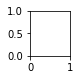

In [8]:
fig, ax = plt.subplots(figsize = (1,1), constrained_layout = True)
fig.savefig('scream yi/test_1in_x_1in.png', dpi = 300)

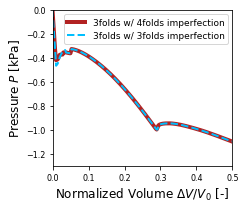

In [15]:
fig, ax = plt.subplots(figsize = (width_half, height_half), constrained_layout = True)


idx_cur = 217
cvol, pcav = np.loadtxt(f'data_out/sim-long-3folds-{idx_cur}_pcav_cvol.txt', unpack = True)
vol_norm = -(cvol - cvol[0])/cvol[0]
pressure_kpa = pcav * 1e3

ax.plot(vol_norm,pressure_kpa, label = f'3folds w/ 4folds imperfection', color = 'firebrick', linewidth = linewidth_all + 2)

idx_cur = 218
cvol, pcav = np.loadtxt(f'data_out/sim-long-3folds-{idx_cur}_pcav_cvol.txt', unpack = True)
vol_norm = -(cvol - cvol[0])/cvol[0]
pressure_kpa = pcav * 1e3

ax.plot(vol_norm,pressure_kpa, '--', label = f'3folds w/ 3folds imperfection', color = 'deepskyblue', linewidth = linewidth_all)

improve_plot(ax, xlabel = vol_label, ylabel = pressure_label, ylim_top = 0, ylim_bottom = -1.3, xlim_left = 0, xlim_right = 0.5)
ax.legend(fontsize = fontsize_legend, loc = 'upper right')

fig.savefig('figures_paper/3folds_diff_imper_modes.png', dpi = 300)
fig.savefig('figures_paper/3folds_diff_imper_modes.pdf')


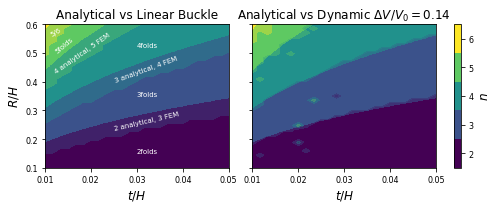

In [20]:
fig, ax = plt.subplots(1,2,figsize = (width_whole, height_half), constrained_layout = True, sharey = True)

'''analytical'''
num_values = np.unique(res_all)
xv, yv = np.meshgrid(v_R_try, v_t_try, indexing='ij')
levels_set = np.arange(6) + 1.5
map_thing = ax[0].contourf(yv, xv, res_all, levels = levels_set, vmin = 2, vmax = 6)
map_thing = ax[1].contourf(yv, xv, res_all, levels = levels_set, vmin = 2, vmax = 6)

cbar = fig.colorbar(map_thing, ticks=[2,3,4,5,6])
cbar.ax.set_yticklabels(['2', '3', '4', '5', '6'])

'''fem- lin buckling'''
num_try_t_fem = 25
num_try_R_fem = 35
v_R_try_fem = np.linspace(0.1,0.6, num_try_R_fem) #R/H
v_t_try_fem = np.linspace(0.01,0.05, num_try_t_fem) #t/H

res_all_fem = np.loadtxt('data_out/initial_mode_tests.txt', dtype = int)
xv, yv = np.meshgrid(v_R_try_fem, v_t_try_fem, indexing='ij')
map_thing = ax[0].contourf(yv, xv, res_all_fem, levels = levels_set, vmin = 2, vmax = 6, alpha = 0.4)

'''fem- dyn imp'''
num_try_t_fem = 25
num_try_R_fem = 35
v_R_try_fem = np.linspace(0.1,0.6, num_try_R_fem) #R/H
v_t_try_fem = np.linspace(0.01,0.05, num_try_t_fem) #t/H

res_all_fem = np.loadtxt('data_out/dyn_mode_tests_nonlin.txt', dtype = int)
xv, yv = np.meshgrid(v_R_try_fem, v_t_try_fem, indexing='ij')
map_thing = ax[1].contourf(yv, xv, res_all_fem, levels = levels_set, vmin = 2, vmax = 6, alpha = 0.4)


# cbar = fig.colorbar(map_thing, ticks=[2,3,4,5,6])
# cbar.ax.set_yticklabels(['2', '3', '4', '5', '6'])
cbar.ax.tick_params(labelsize = fontsize_ticks)
cbar.ax.set_ylabel('$n$', fontsize = fontsize_axes)
# ax[0].set_ylabel('$R/H$', fontsize = 20)
# ax[0].set_ylim(np.min(v_R_try), np.max(v_R_try))

ax[0].set_title('Analytical vs Linear Buckle', fontsize = fontsize_axes)
ax[1].set_title('Analytical vs Dynamic $\Delta V/V_0 = 0.14$', fontsize = fontsize_axes)

improve_plot_multi(ax, xlabel = '$t/H$', ylabel = '$R/H$', xlim_left = np.min(v_t_try), xlim_right = np.max(v_t_try), ylim_bottom = np.min(v_R_try), ylim_top = np.max(v_R_try), sharey = True)

# for axis in ax:
#     axis.set_xlabel('$t/H$', fontsize = 20)
#     axis.tick_params(labelsize = 14)
#     axis.set_xlim(np.min(v_t_try), np.max(v_t_try))

fontsize_label = 7

ax[0].text(0.03, 0.15, '2folds', color = 'white', fontsize = fontsize_label)
ax[0].text(0.025, 0.23, '2 analytical, 3 FEM', color = 'white', fontsize = fontsize_label, rotation = 13)
ax[0].text(0.03, 0.35, '3folds', color = 'white', fontsize = fontsize_label)
ax[0].text(0.025, 0.4, '3 analytical, 4 FEM', color = 'white', fontsize = fontsize_label, rotation = 20)
ax[0].text(0.03, 0.52, '4folds', color = 'white', fontsize = fontsize_label)
ax[0].text(0.012, 0.43, '4 analytical, 5 FEM', color = 'white', fontsize = fontsize_label, rotation = 35)
ax[0].text(0.012, 0.5, '5folds', color = 'white', fontsize = fontsize_label, rotation = 40)
ax[0].text(0.011, 0.56, '5/6', color = 'white', fontsize = fontsize_label, rotation = 30)

fig.savefig(f'{folder_out}/analytical_vs_buckle_vs_dyn_imp.png', dpi = 300)
fig.savefig(f'{folder_out}/analytical_vs_buckle_vs_dyn_imp.pdf')

3folds twist onset: \Delta V/V_0 = 0.285
4folds twist onset: \Delta V/V_0 = 0.204


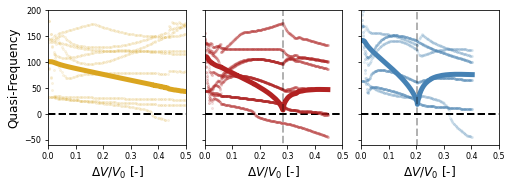

In [17]:
'current freq plots 1x3 new style'
fig, ax = plt.subplots(1,3,figsize = (width_complete, height_three), constrained_layout = True, sharey = True)

for axis in ax: axis.hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)

plot_freq(ax[0], 2)

plot_freq(ax[1], 3)

plot_freq(ax[2], 4)

plot_highlighted_mode_piecewise(ax[0], 2, [0,1], [[4,4]], [2], [1], [-1])

plot_highlighted_mode_piecewise(ax[1], 3, [0,1], [[2,2], [5,5], [3,3], [1,1]], [20, 2, 4, 2], [1, 4, 2, 1], [-320, -190, -145, -1], vert_line = True)

plot_highlighted_mode_piecewise(ax[2], 4, [0,1], [[2,2], [0,2]], [4,2], [1,1], [-109, -1], vert_line = True)

# plot_vert_line_freq(ax[2], 4, idx_paste, alpha = 0.3)

improve_plot_multi(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = 'Quasi-Frequency', ylim_top = 200, ylim_bottom = -60, xlim_left = 0, xlim_right = 0.5, sharey = True)

fig.savefig(f'{folder_out}/SI_freq_all.png', dpi = 300)

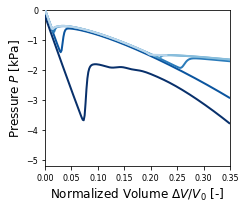

In [19]:
damping_sweep = 2*np.logspace(-10, -4, 7)

# fig, ax = plt.subplots(figsize = (14,10))
fig, ax = plt.subplots(figsize = (width_half, height_half), constrained_layout = True)

initial_idx = 510

# idx_cur = 557
# data_cur = np.loadtxt(f'data_out/4fold-fitting-{idx_cur}_pcav_cvol.txt')
# vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
# pressure_kpa = data_cur[:,1] * 1e3
# print(data_cur[0,0])

# ax.plot(vol_norm,pressure_kpa, '--', label = 'dyn imp 4folds', color = 'steelblue', linewidth = 5)

cmap_all = ['Blues', 'Reds','Greens', 'Oranges', 'Purples', 'Greys', 'BuGn', 'YlOrBr', 'PuRd', 'YlGn']


for i,stab_fac in enumerate(damping_sweep):
    if i > 0:
        zorder = 5*(len(damping_sweep) - i)
        idx_cur = initial_idx + i
        data_path = f'data_out/4fold-test_static-stable-{idx_cur}_pcav_cvol.txt'
        data_cur = np.loadtxt(data_path)
        
        vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
        pressure_kpa = data_cur[:,1] * 1e3

        # color_plot = plt.get_cmap(cmap_all[i])(0.7)
        val_color = (i + 1)/len(damping_sweep)
        color_plot = plt.get_cmap('Blues')(val_color)

        ax.plot(vol_norm,pressure_kpa, label = rf'$f$ = {stab_fac:.0e}', color = color_plot, linewidth = linewidth_all, zorder = zorder)

# ax.legend(loc = 'best', fontsize = fontsize_legend)
improve_plot(ax, xlabel = vol_label, ylabel = pressure_label, ylim_top = 0, ylim_bottom = -5.2, xlim_left = 0, xlim_right = 0.35)

fig.savefig(f'{folder_out}/static_single_sweep_f.png', dpi = 300)
fig.savefig(f'{folder_out}/static_single_sweep_f.pdf')

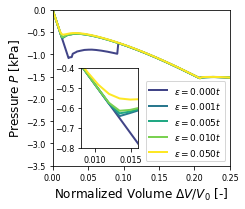

In [21]:
imper_sweep = [0.0, 0.001, 0.005, 0.01, 0.05]

# fig, ax = plt.subplots(figsize = (14,10))
fig, ax = plt.subplots(figsize = (width_half, height_half), constrained_layout = True)
ax_in = ax.inset_axes([0.04, -3.1, 0.08, 1.8], transform=ax.transData)

initial_idx = 120



cmap_all = ['Blues', 'Reds','Greens', 'Oranges', 'Purples', 'Greys', 'BuGn', 'YlOrBr', 'PuRd', 'YlGn']


for i,imper in enumerate(imper_sweep):
    zorder = 5*(len(imper_sweep) - i)
    idx_cur = initial_idx + i
    data_path = f'data_out/imper-test-4fold-v{idx_cur}_pcav_cvol.txt'
    data_cur = np.loadtxt(data_path)
    
    vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
    pressure_kpa = data_cur[:,1] * 1e3

    # color_plot = plt.get_cmap(cmap_all[i])(0.7)
    # if i == 0:
    #     ax.vlines(vol_norm[62], -5, 0, 'k', '--')
    val_color = (i + 1)/len(imper_sweep)
    color_plot = plt.get_cmap('viridis')(val_color)

    ax.plot(vol_norm,pressure_kpa, label = rf'$\varepsilon = ${imper:.3f}$t$', color = color_plot, linewidth = linewidth_all)
    ax_in.plot(vol_norm,pressure_kpa, label = rf'$f$ = {imper:.3f}$t$', color = color_plot, linewidth = linewidth_all)

ax.legend(loc = 'lower right', fontsize = fontsize_legend)
improve_plot(ax, xlabel = vol_label, ylabel = pressure_label, ylim_top = 0, ylim_bottom = -3.5, xlim_left = 0, xlim_right = 0.25)
improve_plot(ax_in, ylim_top = -0.4, ylim_bottom = -0.8, xlim_left = 0.008, xlim_right = 0.016)

fig.savefig('figures_paper/4folds_imper_value.png', dpi = 300)
fig.savefig('figures_paper/4folds_imper_value.pdf')

max \Delta V_norm = 1.098e-02


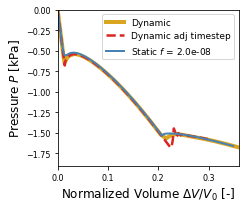

In [23]:
'''test dyn vs static multi vs static single step'''
imper_vals = 5*np.logspace(-4, -2, 3)

# fig, ax = plt.subplots(figsize = (14,10))
fig, ax = plt.subplots(figsize = (width_half, height_half), constrained_layout = True)



cmap_all = ['Blues', 'Reds','Greens', 'Oranges', 'Purples', 'Greys', 'BuGn', 'YlOrBr', 'PuRd', 'YlGn']


idx_cur = 557
data_cur = np.loadtxt(f'data_out/4fold-fitting-{idx_cur}_pcav_cvol.txt')
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3
# print(data_cur[0,0])

ax.plot(vol_norm,pressure_kpa, '-', label = 'Dynamic', color = 'goldenrod', linewidth = 4, markersize = 9)
print(f'max \Delta V_norm = {np.max(np.diff(vol_norm)):.3e}')


idx_cur = 218
data_path = f'data_out/4fold-imperfection-{idx_cur}_pcav_cvol.txt'

data_cur = np.loadtxt(data_path)
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3

color_plot = plt.get_cmap('Reds')(0.7)

ax.plot(vol_norm,pressure_kpa, '--', label = 'Dynamic adj timestep', color = color_plot, linewidth = 2.5, markersize = 8)

idx_cur = 231
data_path = f'data_out/4fold-imperfection-{idx_cur}_pcav_cvol.txt'

data_cur = np.loadtxt(data_path)
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3

color_plot = 'steelblue'

ax.plot(vol_norm,pressure_kpa, '-', label = f'Static $f$ = {2e-8:.1e}', color = color_plot, linewidth = linewidth_all, markersize = 8)


improve_plot(ax, xlabel = vol_label, ylabel = pressure_label, ylim_top = 0, ylim_bottom = -1.9, xlim_left = 0, xlim_right = 0.36)
ax.legend(loc = 'best', fontsize = fontsize_legend)



fig.savefig(f'{folder_out}/dyn_vs_static.png', dpi = 300)
fig.savefig(f'{folder_out}/dyn_vs_static.pdf')
